# GoogLeNet, Inception

이번에는 **GoogLeNet**, 또는 **Inception**으로 알려진 모델을 중심으로 TensorFlow와 PyTorch를 사용하여 직접 구현해보겠습니다.

또한, **전이 학습(Transfer Learning)**을 통해 사전 학습된 Inception 모델을 불러와 사용하는 방법을 알아보겠습니다.

## 1. GoogLeNet (Inception) 소개

### 1.1 GoogLeNet이란?

- GoogLeNet은 2014년 ILSVRC(ImageNet Large Scale Visual Recognition Competition)에서 VGGNet을 제치고 우승한 모델로, **6.67%**의 상위-5 오류율(top-5 error rate)을 기록했습니다.

- Inception 모듈이라는 혁신적인 아이디어를 도입하여 네트워크의 깊이와 너비를 효율적으로 증가시켰습니다.

### 특징
- 인셉션 블록이라는 개념을 사용하여 다양한 크기의 필터를 병렬로 적용하고, 그 결과를 채널 방향으로 결합하는 **인셉션 네트워크(Inception Network)**을 사용합니다.

  <img src="https://miro.medium.com/max/2800/0*rbWRzjKvoGt9W3Mf.png">


- CNN 계산 용량을 최적화하는 것을 고려
  - 전형적인 합성곱, 풀링 계층으로 시작하고, 이 정보는 9개의 인셉션 모듈 스택을 통과 (해당 모듈을 하위 네트워크라고도 함)
  - 각 모듈에서 입력 특징 맵은 서로 다른 계층으로 구성된 4개의 병렬 하위 블록에 전달되고, 이를 서로 다시 연결
  - 모든 합성곱과 풀링 계층의 `padding`옵션은 `'SAME'`이며 `stride=1` 활성화 함수는 `ReLU` 사용

- 1x1 합성곱을 사용하여 차원 축소 및 계산 효율성을 높였습니다.

- Global Average Pooling을 사용하여 완전 연결 계층의 파라미터 수를 줄였습니다.

- **보조 분류기(Auxiliary Classifier)**를 사용하여 학습 과정에서의 기울기 소실(Vanishing Gradient)을 방지했습니다.



- 기여
  - 규모가 큰 블록과 병목을 보편화
  - 병목 계층으로 1x1 합성곱 계층 사용
  - 완전 연결 계층 대신 풀링 계층 사용
  - 중간 소실로 경사 소실 문제 해결

  <img src="https://norman3.github.io/papers/images/google_inception/f01.png">

## 2. TensorFlow를 사용한 GoogLeNet 구현

### 2.1 필요한 라이브러리 Import

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.layers import Input, Dropout, Concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

### 2.2 Inception 모듈 구현

Inception 모듈은 여러 크기의 필터를 병렬로 적용하고, 그 결과를 결합하는 구조입니다.

In [ ]:
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3,
                     filters_5x5_reduce, filters_5x5, filters_pool_proj, name=None):
    # 1x1 convolution branch
    conv_1x1 = Conv2D(filters_1x1, (1,1), padding='same', activation='relu')(x)

    # 1x1 -> 3x3 convolution branch
    conv_3x3 = Conv2D(filters_3x3_reduce, (1,1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3,3), padding='same', activation='relu')(conv_3x3)

    # 1x1 -> 5x5 convolution branch
    conv_5x5 = Conv2D(filters_5x5_reduce, (1,1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, (5,5), padding='same', activation='relu')(conv_5x5)

    # Pooling branch
    pool_proj = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1,1), padding='same', activation='relu')(pool_proj)

    # Concatenate filters
    output = Concatenate(axis=3, name=name)([conv_1x1, conv_3x3, conv_5x5, pool_proj])

    return output

- 1x1 Convolution Branch
    - 저수준 특징을 추출합니다.
- 1x1 -> 3x3 Convolution Branch
    - 중간 수준의 특징을 추출합니다.
- 1x1 -> 5x5 Convolution Branch
    - 고수준의 특징을 추출합니다.
- Pooling Branch
    - 특징 맵의 크기를 줄이면서 중요한 특징을 유지합니다.
- Concatenation
    - 모든 브랜치의 출력을 채널 방향으로 결합하여 다음 계층으로 전달합니다.

### 2.3 전체 모델 구성

In [ ]:
def build_googlenet():
    input_layer = Input(shape=(224, 224, 3))

    # Pre-layers
    x = Conv2D(64, (7,7), strides=(2,2), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
    x = Conv2D(64, (1,1), padding='same', activation='relu')(x)
    x = Conv2D(192, (3,3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

    # Inception Modules
    x = inception_module(x,
                         filters_1x1=64,
                         filters_3x3_reduce=96,
                         filters_3x3=128,
                         filters_5x5_reduce=16,
                         filters_5x5=32,
                         filters_pool_proj=32,
                         name='inception_3a')

    x = inception_module(x,
                         filters_1x1=128,
                         filters_3x3_reduce=128,
                         filters_3x3=192,
                         filters_5x5_reduce=32,
                         filters_5x5=96,
                         filters_pool_proj=64,
                         name='inception_3b')

    x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

    x = inception_module(x,
                         filters_1x1=192,
                         filters_3x3_reduce=96,
                         filters_3x3=208,
                         filters_5x5_reduce=16,
                         filters_5x5=48,
                         filters_pool_proj=64,
                         name='inception_4a')

    x = inception_module(x,
                         filters_1x1=160,
                         filters_3x3_reduce=112,
                         filters_3x3=224,
                         filters_5x5_reduce=24,
                         filters_5x5=64,
                         filters_pool_proj=64,
                         name='inception_4b')

    x = inception_module(x,
                         filters_1x1=128,
                         filters_3x3_reduce=128,
                         filters_3x3=256,
                         filters_5x5_reduce=24,
                         filters_5x5=64,
                         filters_pool_proj=64,
                         name='inception_4c')

    x = inception_module(x,
                         filters_1x1=112,
                         filters_3x3_reduce=144,
                         filters_3x3=288,
                         filters_5x5_reduce=32,
                         filters_5x5=64,
                         filters_pool_proj=64,
                         name='inception_4d')

    x = inception_module(x,
                         filters_1x1=256,
                         filters_3x3_reduce=160,
                         filters_3x3=320,
                         filters_5x5_reduce=32,
                         filters_5x5=128,
                         filters_pool_proj=128,
                         name='inception_4e')

    x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

    x = inception_module(x,
                         filters_1x1=256,
                         filters_3x3_reduce=160,
                         filters_3x3=320,
                         filters_5x5_reduce=32,
                         filters_5x5=128,
                         filters_pool_proj=128,
                         name='inception_5a')

    x = inception_module(x,
                         filters_1x1=384,
                         filters_3x3_reduce=192,
                         filters_3x3=384,
                         filters_5x5_reduce=48,
                         filters_5x5=128,
                         filters_pool_proj=128,
                         name='inception_5b')

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(1000, activation='softmax')(x)

    model = Model(input_layer, output_layer)

    return model

# 모델 인스턴스 생성
googlenet = build_googlenet()

1. Pre-layers

    - Conv2D
        - 7x7 필터, 스트라이드 2로 입력 이미지를 다운샘플링합니다.
    - MaxPooling2D
        - 3x3 풀링으로 특징 맵의 크기를 줄입니다.
    - 추가적인 Conv2D 계층을 통해 더 많은 특징을 추출합니다.

2. Inception Modules

    - 여러 개의 인셉션 모듈을 연속적으로 적용하여 깊이 있는 특징을 추출합니다.
    - 각 인셉션 모듈은 다양한 크기의 필터를 사용하여 복잡한 패턴을 학습합니다.

3. Global Average Pooling 및 완전 연결 계층

    - GlobalAveragePooling2D
        - 특징 맵의 공간 차원을 평균화하여 차원을 축소합니다.
    - Dropout
        - 과적합을 방지하기 위해 일부 뉴런을 무작위로 비활성화합니다.
    - Dense
        - 최종 분류를 위해 소프트맥스 활성화 함수를 사용한 완전 연결 계층을 추가합니다.

### 2.4 모델 요약
모델의 구조와 파라미터 수를 확인하기 위해 summary를 사용합니다.

In [ ]:
# TensorFlow 모델 요약
googlenet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 192)    │        110,784 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 28, 28, 192)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 28, 28, 96)     │         18,528 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 28, 28, 16)     │          3,088 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 192)    │              0 │ max_pooling2d_1[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 28, 28, 64)     │         12,352 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 28, 28, 128)    │        110,720 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 28, 28, 32)     │         12,832 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 28, 28, 32)     │          6,176 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_3a              │ (None, 28, 28, 256)    │              0 │ conv2d_3[0][0],        │
│ (Concatenate)             │                        │                │ conv2d_5[0][0],        │
│                           │                        │                │ conv2d_7[0][0],        │
│                           │                        │                │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 28, 28, 128)    │         32,896 │ inception_3a[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 28, 28, 32)     │          8,224 │ inception_3a[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3      

 Total params: 6,998,552 (26.70 MB)

 Trainable params: 6,998,552 (26.70 MB)

 Non-trainable params: 0 (0.00 B)

### 모델 요약 출력

- 각 층의 출력 형태와 파라미터 수를 확인할 수 있습니다.
- GoogLeNet은 약 7백만 개의 파라미터를 가지고 있습니다.

### 2.5 모델 학습

- 실제로 모델을 학습시키려면 대량의 데이터와 긴 학습 시간이 필요합니다.
- 따라서 여기서는 모델 구조 구현에 초점을 맞추고, 전이 학습을 통해 사전 학습된 모델을 사용하는 방법을 알아보겠습니다.

## 3. PyTorch를 사용한 GoogLeNet 구현

### 3.1 필요한 라이브러리 Import

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### 3.2 Inception 모듈 구현

In [ ]:
class Inception(nn.Module):
    def __init__(self, in_channels, out_1x1,
                 red_3x3, out_3x3,
                 red_5x5, out_5x5,
                 out_pool):
        super(Inception, self).__init__()

        # 1x1 conv branch
        self.branch1 = nn.Conv2d(in_channels, out_1x1, kernel_size=1)

        # 1x1 conv -> 3x3 conv branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(red_3x3, out_3x3, kernel_size=3, padding=1)
        )

        # 1x1 conv -> 5x5 conv branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(red_5x5, out_5x5, kernel_size=5, padding=2)
        )

        # Pooling branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1)
        )

    def forward(self, x):
        branch1 = F.relu(self.branch1(x))
        branch2 = F.relu(self.branch2(x))
        branch3 = F.relu(self.branch3(x))
        branch4 = F.relu(self.branch4(x))

        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)

- Branch1: 단순 1x1 합성곱으로 저수준 특징을 추출합니다.
- Branch2: 1x1 합성곱으로 차원을 축소한 후, 3x3 합성곱으로 중간 수준의 특징을 추출합니다.
- Branch3: 1x1 합성곱으로 차원을 축소한 후, 5x5 합성곱으로 고수준의 특징을 추출합니다.
- Branch4: 3x3 맥스 풀링을 수행한 후, 1x1 합성곱으로 특징을 추출합니다.
- Concatenation: 모든 브랜치의 출력을 채널 방향으로 결합하여 다음 계층으로 전달합니다.

### 3.3 전체 모델 구성

In [ ]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Conv2d(64, 64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1)
        )

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(0.4)
        self.linear = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.linear(x)
        return x

# 모델 인스턴스 생성
googlenet = GoogLeNet()

1. Pre-layers

    - 초기 합성곱과 풀링 계층을 통해 입력 이미지의 크기를 줄이고, 기본적인 특징을 추출합니다.

2. Inception Modules

    - 여러 개의 Inception 모듈을 연결하여 복잡한 패턴을 학습합니다.

3. Pooling and Final Layers:

    - AvgPool2d와 Dropout을 통해 과적합을 방지하고, Linear 레이어로 최종 분류를 수행합니다.

### 3.4 모델 요약

In [ ]:
# device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
googlenet.to(device)

# torchsummary로 summary 하는 방법
from torchsummary import summary
summary(googlenet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
              ReLU-2         [-1, 64, 112, 112]               0
         MaxPool2d-3           [-1, 64, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]           4,160
              ReLU-5           [-1, 64, 56, 56]               0
            Conv2d-6          [-1, 192, 56, 56]         110,784
              ReLU-7          [-1, 192, 56, 56]               0
         MaxPool2d-8          [-1, 192, 28, 28]               0
            Conv2d-9           [-1, 64, 28, 28]          12,352
           Conv2d-10           [-1, 96, 28, 28]          18,528
             ReLU-11           [-1, 96, 28, 28]               0
           Conv2d-12          [-1, 128, 28, 28]         110,720
           Conv2d-13           [-1, 16, 28, 28]           3,088
             ReLU-14           [-1, 16,

In [ ]:
# 모델 요약 출력
!pip install torchinfo

batch_size= 32

from torchinfo import summary
# to match the expected input channels (3 for RGB) and image size (224x224)
# for the GoogLeNet model.
summary(googlenet, input_size=(batch_size, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
GoogLeNet                                [32, 1000]                --
├─Sequential: 1-1                        [32, 192, 28, 28]         --
│    └─Conv2d: 2-1                       [32, 64, 112, 112]        9,472
│    └─ReLU: 2-2                         [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-3                    [32, 64, 56, 56]          --
│    └─Conv2d: 2-4                       [32, 64, 56, 56]          4,160
│    └─ReLU: 2-5                         [32, 64, 56, 56]          --
│    └─Conv2d: 2-6                       [32, 192, 56, 56]         110,784
│    └─ReLU: 2-7                         [32, 192, 56, 56]         --
│    └─MaxPool2d: 2-8                    [32, 192, 28, 28]         --
├─Inception: 1-2                         [32, 256, 28, 28]         --
│    └─Conv2d: 2-9                       [32, 64, 28, 28]          12,352
│    └─Sequential: 2-10                  [32, 128, 28, 28]         --


- 모델 요약 출력

    - 각 층의 출력 형태와 파라미터 수를 확인할 수 있습니다.
    - GoogLeNet은 약 7백만 개의 파라미터를 가지고 있습니다.

### 3.5 모델 학습

- 실제로 모델을 학습시키려면 대량의 데이터와 긴 학습 시간이 필요합니다.
- 따라서 여기서는 모델 구조 구현에 초점을 맞추고, 전이 학습을 통해 사전 학습된 모델을 사용하는 방법을 알아보겠습니다.

## 4. 전이 학습을 통한 사전 학습된 Inception 모델 사용

전이 학습은 사전 학습된 모델의 가중치를 재사용하여 새로운 작업에 빠르게 적응하는 방법입니다. 이를 통해 학습 시간을 절약하고 높은 성능을 얻을 수 있습니다.

## 4.1 TensorFlow에서의 전이 학습

### 4.1.1 필요한 라이브러리 Import

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

### 4.1.2 사전 학습된 InceptionV3 모델 로드

In [ ]:
# 사전 학습된 InceptionV3 모델 로드
inception = InceptionV3(include_top=True, weights='imagenet')

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


- include_top=True로 설정하여 완전 연결 계층까지 포함합니다.
- weights='imagenet'로 설정하여 ImageNet 데이터셋으로 학습된 가중치를 불러옵니다.

### 4.1.3 이미지 불러오기 및 전처리

--2024-10-24 19:40:48--  https://upload.wikimedia.org/wikipedia/commons/7/7a/Goldfish_1.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 185.15.59.240, 2a02:ec80:300:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|185.15.59.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4648040 (4.4M) [image/jpeg]
Saving to: ‘fish.jpg’

fish.jpg            100%[===================>]   4.43M  9.51MB/s    in 0.5s    

2024-10-24 19:40:48 (9.51 MB/s) - ‘fish.jpg’ saved [4648040/4648040]



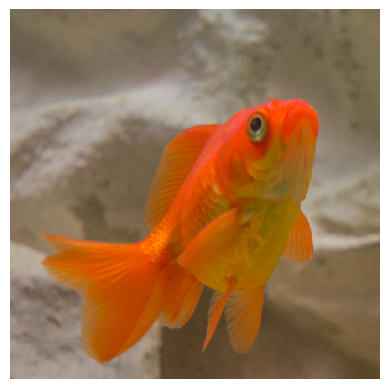

In [ ]:
# 이미지 다운로드 (예: 물고기 사진)
!wget -O fish.jpg https://upload.wikimedia.org/wikipedia/commons/7/7a/Goldfish_1.jpg

# 이미지 로드 및 전처리
img = image.load_img('fish.jpg', target_size=(299, 299))
plt.imshow(img)
plt.axis('off')
plt.show()

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

- InceptionV3 모델은 입력 크기가 299x299x3입니다.
- preprocess_input 함수를 사용하여 전처리를 수행합니다.

### 4.1.4 예측 및 결과 해석

In [ ]:
# 예측 수행
preds = inception.predict(x)

# 예측 결과 디코딩
print('Predicted:', decode_predictions(preds, top=5)[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Predicted: [('n01443537', 'goldfish', 0.9748253), ('n02701002', 'ambulance', 0.0023263101), ('n02606052', 'rock_beauty', 0.0019094155), ('n02607072', 'anemone_fish', 0.00066422706), ('n09256479', 'coral_reef', 0.0004322435)]


예측 결과:

- 가장 높은 확률로 goldfish(금붕어)로 분류되었습니다.

## 4.2 PyTorch에서의 전이 학습

### 4.2.1 필요한 라이브러리 Import

In [ ]:
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import torch

### 4.2.2 사전 학습된 InceptionV3 모델 로드

In [ ]:
# 사전 학습된 InceptionV3 모델 로드
inception = models.inception_v3(pretrained=True)
inception.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 157MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

- pretrained=True로 설정하여 ImageNet 가중치를 불러옵니다.
- eval() 메서드를 호출하여 모델을 평가 모드로 전환합니다.

### 4.2.3 이미지 불러오기 및 전처리

In [ ]:
# 이미지 로드
img = Image.open('fish.jpg')

# 이미지 전처리
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet의 평균
        std=[0.229, 0.224, 0.225]    # ImageNet의 표준편차
    )
])

img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)

- InceptionV3 모델은 입력 크기가 299x299x3입니다.
- 이미지를 텐서로 변환하고, 정규화합니다.

### 4.2.4 예측 및 결과 해석

In [ ]:
# 예측 수행
with torch.no_grad():
    out = inception(batch_t)

# ImageNet의 클래스 인덱스 로드
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

with open('imagenet_classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]

# 예측 결과 확인
probabilities = torch.nn.functional.softmax(out[0], dim=0)
top5_prob, top5_catid = torch.topk(probabilities, 5)

for i in range(top5_prob.size(0)):
    print(classes[top5_catid[i]], top5_prob[i].item())

--2024-10-24 19:41:23--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2024-10-24 19:41:23 (117 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]

goldfish 0.9414170980453491
rock beauty 0.008983248844742775
ambulance 0.0038254468236118555
anemone fish 0.000812120852060616
cash machine 0.0006147175445221364


예측 결과:

- 가장 높은 확률로 goldfish(금붕어)로 분류되었습니다.

## 5. TensorFlow와 PyTorch 구현 비교

- 모델 구현 방식:

    - TensorFlow는 Keras의 함수형 API를 사용하여 모델을 구성하였으며, Concatenate를 사용하여 출력들을 결합했습니다.
    - PyTorch는 클래스 기반으로 모델을 구현하였으며, 각 모듈을 nn.Module로 정의하고 torch.cat을 사용하여 출력들을 결합했습니다.

- Inception 모듈 구현:

    - 두 프레임워크 모두 Inception 모듈을 별도의 함수나 클래스로 정의하여 코드의 재사용성과 가독성을 높였습니다.
    - 각 경로를 명확하게 정의하고 결합하는 방식은 유사합니다.

- 전이 학습 사용 방법:

    - TensorFlow는 tensorflow.keras.applications 모듈을 사용하여 사전 학습된 모델을 불러옵니다.
    - PyTorch는 torchvision.models를 사용하여 사전 학습된 모델을 불러옵니다.
    - 두 프레임워크 모두 간단한 코드로 사전 학습된 모델을 사용할 수 있습니다.

- 이미지 전처리:

    - 두 프레임워크 모두 모델에 맞는 입력 크기와 정규화를 적용해야 합니다.
    - TensorFlow는 preprocess_input 함수를 제공하여 전처리를 쉽게 수행할 수 있습니다.
    - PyTorch는 transforms를 사용하여 전처리를 구성합니다.

- 예측 결과 해석:

    - TensorFlow는 decode_predictions 함수를 제공하여 예측 결과를 해석합니다.
    - PyTorch는 별도로 클래스 인덱스 파일을 불러와서 매핑해야 합니다.

## 6. 결론

- 우리는 이번에 **GoogLeNet (Inception)**의 구조와 특징을 이해하고, TensorFlow와 PyTorch에서 직접 구현해보았습니다.

- Inception 모듈의 구현을 통해 모델의 핵심 아이디어를 살펴보았습니다.

- 또한, 전이 학습을 통해 사전 학습된 모델을 불러와 사용하는 방법을 알아보았습니다.

- 두 프레임워크 모두 사전 학습된 모델을 쉽게 사용할 수 있으며, 이를 통해 모델 학습 시간을 절약하고 높은 성능을 얻을 수 있습니다.

- TensorFlow와 PyTorch의 모델 구현 방식과 사용 방법을 비교하여 이해함으로써, 상황에 맞는 프레임워크를 선택하고 활용할 수 있습니다.

## 7. 과제

### 과제 1: GoogLeNet (Inception) 모델 구조 타이핑 및 이해

- 목표

    - GoogLeNet (Inception) 모델의 구조를 직접 타이핑해보면서 각 레이어가 어떻게 쌓이는지 연습해보세요.

- 방법
    - TensorFlow 또는 PyTorch를 선택하여 GoogLeNet 모델의 코드를 한 번 타이핑해보세요.
    - 각 레이어의 역할과 파라미터 수를 주석으로 달아가며 이해를 돕습니다.

### 과제 2: GoogLeNet (Inception) 모델 조사 및 정리

- 목표

    - GoogLeNet (Inception) 모델에 대해 추가로 연구하고, 해당 모델에 대해 정리해보세요.

- 방법

    - GoogLeNet의 역사와 발전 과정에 대해 조사해보세요.
    - Inception 모듈의 다양한 변형(Inception v1, v2, v3 등)에 대해 알아보세요.
    - GoogLeNet이 다른 CNN 모델과 비교했을 때 가지는 장단점을 정리해보세요.
    - 자신의 말로 이해한 내용을 문서화하여 공유해주세요.

### 과제 3: 사전 학습된 Inception 모델을 사용한 분류 실습

- 목표

    - 사전 학습된 Inception 모델을 사용하여 자신만의 이미지를 분류해보세요.

- 방법

    - TensorFlow 또는 PyTorch를 선택하여 사전 학습된 Inception 모델을 불러옵니다.
    - 분류하고자 하는 이미지를 선택하여 전처리합니다.
    - 모델을 사용하여 이미지를 분류하고, 예측 결과를 해석합니다.
결과를 시각화하여 공유해주세요.